## Predict Future Sales

### 目录 
- **问题描述**
- **数据描述**
- **数据预处理** 
 - *导入数据*
 - *数据特征*
 - *检查异常值*
 - *处理异常值* 
- **特征工程**
 - *特征工程Ⅰ—— 特征拆分*
 - *特征工程Ⅱ—— 特征聚合*
 - *特征工程Ⅲ—— lag生成新特征*
 - *特征工程Ⅳ—— 价格趋势*
- **模型建立**
 - *时间序列模型*
 - *LSTM*
 - *XGBRegressor*
 - *LGBMRegressor*
- **模型评估**

### 问题描述 
#### 根据历史的销售数据，建立一个鲁棒性高的模型，预测每家商店所有商品下一个月的销售量###  
  
### 数据描述
- **sales_train.csv** - 训练集. 历史的每天的销售数据，从2013年1月到2015年10月
- **test.csv** - 测试集. 需要预测每家商店每件商店的11月份的销售量.
- **sample_submission.csv** - 提交结果的例子.
- **items.csv** - 商品的信息.
- **item_categories.csv**  - 商品种类的信息.
- **shops.csv** - 商店的信息.

In [90]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# from xgboost import XGBRegressor
# from xgboost import plot_importance
from lightgbm import LGBMRegressor
from lightgbm import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
from tqdm import tqdm
sys.version_info

sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)

### 数据预处理

#### 导入数据
----------------------------------------------------------------------------------

In [140]:
items = pd.read_csv('input/items.csv')
shops = pd.read_csv('input/shops.csv')
cats = pd.read_csv('input/item_categories.csv')
train = pd.read_csv('input/sales_train.csv.gz')
test  = pd.read_csv('input/test.csv.gz').set_index('ID')

#### 数据特征
-----------------------------------------------------------------------------------
- ***ID*** - 测试集中(商店，项目)元组的id
- ***shop_id***：离散值 - 商店id, [0, 59]
- ***item_id***: 离散值 - 商品id, [0, 22169]
- ***item_category_id*** - 商品类别id，[0, 84]
- ***item_cnt_day*** - 连续值; 商品的销量
- ***item_price*** - 连续值; 商品价格
- ***date*** - 日期
- ***date_block_num*** - 离散值; 日期，2013年1月为0，2013年2月为1..到2015年10月为33.
- ***item_name*** - 商品名称
- ***shop_name*** - 商店名称
- ***item_category_name*** - 类别名称

In [141]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [142]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


#### 检查异常值
----------------------------------------------------------------------------------
- 绘制特征***item_cnt_day***的箱式图  
    ***item_cnt_day***存在异常值，即销量超过1000
- 绘制特征***item_price***的箱式图  
    ***item_price***存在异常值，即价格超过300000的商品
- 存在某个item的价格低于0 

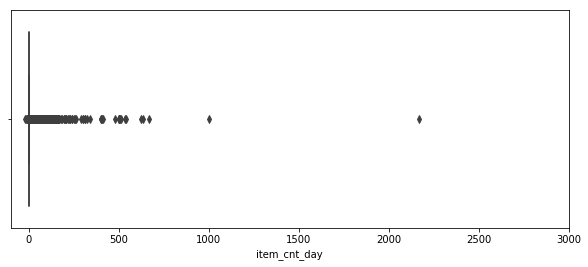

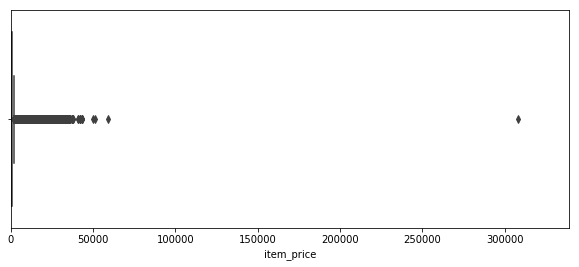

In [143]:
plt.figure(figsize=(10, 4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10, 4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

####  处理异常值
----------------------------------------------------------------------------------
- 去除商品价格大于100000的商品记录
- 去除商品销量大于1000的商品记录
- 用商品价格的中位数去替换商品价格小于0的商品记录

In [92]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [93]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [94]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

### 特征工程Ⅰ
------------------------------------------------------------------------------
- 商店名字中，***shop_name***中前面是城市名，将其提取出来，单独作为特征***city***
- 商品类别中，***type***中前面是商品种类，后面是第二类别，将其划分为***type***和***subtype***两个特征
- 商品类别中，根据***ttem_category_name***将商品划分为12种大类
- 将以上的特征利用LabelEnconder编码成离散值
- 去掉商品的***item_name***特征

In [95]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

In [96]:
l_cat = list(cats.item_category_name)

for ind in range(0,1):
    l_cat[ind] = 'PC Headsets / Headphones'
for ind in range(1,8):
    l_cat[ind] = 'Access'
l_cat[8] = 'Tickets (figure)'
l_cat[9] = 'Delivery of goods'
for ind in range(10,18):
    l_cat[ind] = 'Consoles'
for ind in range(18,25):
    l_cat[ind] = 'Consoles Games'
l_cat[25] = 'Accessories for games'
for ind in range(26,28):
    l_cat[ind] = 'phone games'
for ind in range(28,32):
    l_cat[ind] = 'CD games'
for ind in range(32,37):
    l_cat[ind] = 'Card'
for ind in range(37,43):
    l_cat[ind] = 'Movie'
for ind in range(43,55):
    l_cat[ind] = 'Books'
for ind in range(55,61):
    l_cat[ind] = 'Music'
for ind in range(61,73):
    l_cat[ind] = 'Gifts'
for ind in range(73,79):
    l_cat[ind] = 'Soft'
for ind in range(79,81):
    l_cat[ind] = 'Office'
for ind in range(81,83):
    l_cat[ind] = 'Clean'
l_cat[83] = 'Elements of a food'

In [97]:
from sklearn import preprocessing
lb = preprocessing.LabelEncoder()
cats['item_cat_id_fix'] = lb.fit_transform(l_cat)

In [98]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code', 'item_cat_id_fix']]

In [99]:
items.drop(['item_name'], axis=1, inplace=True)

### 特征工程Ⅱ
------------------------------------------------------------------------------
- 产生商品和商店之间的关联，每个商品和商店形成一个pair。因为题目中提到商店和产品每个月都会发生变化，且要预测是下个月的销量，所以利用笛卡儿积构建每个月里的商店和商品之间的关联。
- 因为是预测各个商品下个月的销量，而***train***数据集中给出的特征是每天的销量，需要对其进行sum聚合，得到***item_cnt_month***特征
- train数据集中有***item_price***和***item_item_cnt_day***特征，可以构建每日的收入特征***revenue***
- test数据集中加入***date_block_num***特征，设为默认值为下一月的值：34
- 将test数据集加入到train数据集当中，并且将shops，cats，items数据集合并进来

In [100]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [101]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [102]:
test_nrow = test.shape[0]
train = train.merge(test[['shop_id']].drop_duplicates(), how = 'inner')
train['date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')

In [103]:
from itertools import product
grid = []
for block_num in train['date_block_num'].unique():
    cur_shops = train[train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = train[train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

In [104]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [105]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
train['item_cnt_day'] = train['item_cnt_day'].clip(0,20)
gb_cnt = train.groupby(index_cols)['item_cnt_day'].agg(['sum']).reset_index().rename(columns = {'sum': 'item_cnt_month'})
gb_cnt['item_cnt_month'] = gb_cnt['item_cnt_month'].clip(0,20).astype(np.int)
matrix = pd.merge(grid,gb_cnt,how='left',on=index_cols).fillna(0)
matrix['item_cnt_month'] = matrix['item_cnt_month'].astype(int)

In [106]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [107]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)

In [108]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
matrix['item_cat_id_fix'] = matrix['item_cat_id_fix'].astype(np.int8)

### 特征工程Ⅲ
------------------------------------------------------------------------------ 
- 定义*lag_feature*函数，用于将时间序列数据集中的某些特征的滞后处理，产生新的特征。即将某些属性滞后，将前一时间步的值作为新的特征值，或者可以做Multi-Step
- 将***item_cnt_month***特征滞后1到12个月，产生12个新的特征，利用xgboost的回归，初步训练模型，得到新的特征的***importance***值，可以筛选出第1,2,3,6特征作为新的特征
- 将***item_cnt_month***关于***data_block_num***分组，再进行mean聚合，即得到全部商品每个月的平均销量,生成***date_avg_item_cnt***特征，再对该新特征进行滞后，滞后步长分别设为1, 2, 3, 6, 12，再利用lightgbm的回归模型尝试训练，将得到模型进行参数评估，选取了滞后1, 2, 3产生的新特征
- 将***item_cnt_month***关于***data_block_num***,***item_id***分组，再进行mean聚合，即得到每个月每个商品的平均销量，生成***data_item_avg_item_cnt***特征，再对该新特征进行滞后，滞后步长分别设为1到12，再利用lightgbm的回归模型尝试训练，将得到的模型进行参数评估，选取了滞后1,2,4时间步产生的新特征
- 同上面的操作，分别对shop_id,item_category_id,type_code,subtype_code做与data_block_num相关的聚合操作，并进行滞后，筛选了其中importance较高的新特征

**item_cnt_month特征评估**
![avatar](date_avg_item_cnt.png)

**Output:**
<table>
    <tr>
        <td>
        **Valid Accuracy**
        </td>
        <td>
          0.900911
        </td>
    <tr>
        <td>
        **Test Accuracy**
        </td>
        <td>
        0.97235
        </td>
    </tr>
</table>

In [109]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [110]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

**date_item_avg_item_cnt特征评估**
![avatar](date_item_avg_item_cnt.png)

**Output:**
<table>
    <tr>
        <td>
        **Valid Accuracy**
        </td>
        <td>
          0.943278
        </td>
    <tr>
        <td>
        **Test Accuracy**
        </td>
        <td>
        0.95889
        </td>
    </tr>
</table>

In [111]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [112]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [113]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [114]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [115]:
group = matrix.groupby(['date_block_num', 'item_cat_id_fix']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_fix_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_cat_id_fix'], how='left')
matrix['date_cat_fix_avg_item_cnt'] = matrix['date_cat_fix_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_fix_avg_item_cnt')
matrix.drop(['date_cat_fix_avg_item_cnt'], axis=1, inplace=True)

In [116]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_cat_id_fix']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_fix_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_cat_id_fix'], how='left')
matrix['date_shop_cat_fix_avg_item_cnt'] = matrix['date_shop_cat_fix_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_fix_avg_item_cnt')
matrix.drop(['date_shop_cat_fix_avg_item_cnt'], axis=1, inplace=True)

In [117]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [118]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [119]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [120]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [121]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [122]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [123]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

### 特征工程Ⅳ
------------------------------------------------------------------------------ 
- 计算商品的平均价格**item_avg_item_price**，商品每个月的商品价格**date_item_avg_item_price**，并对属性**date_item_avg_item_price**进行lag处理生成，滞后1到6个月的相关特征
- 计算商店每个月的总收入**date_shop_revenue**，计算商店的平均收入**shop_avg_revenue**
- 计算每件商品上一次销售距离当前的时间**item_last_sale**
- 计算每个商店每件商品上一次销售距离当前时间**item_shop_last_sale**

In [124]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [125]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [126]:
matrix['month'] = matrix['date_block_num'] % 12

In [127]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [128]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num   

In [129]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num    

### 模型建立

#### LightGBM

In [130]:
data = matrix[matrix.date_block_num > 11]

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

data = fill_na(matrix)

In [132]:
data = matrix[matrix.date_block_num > 11]

In [134]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [135]:
ts = time.time()

model = LGBMRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[1]	training's rmse: 1.15565	training's l2: 1.33553	valid_1's rmse: 1.04465	valid_1's l2: 1.0913
Training until validation scores don't improve for 10 rounds.
[2]	training's rmse: 1.1162	training's l2: 1.24591	valid_1's rmse: 1.0139	valid_1's l2: 1.028
[3]	training's rmse: 1.08378	training's l2: 1.17457	valid_1's rmse: 0.989438	valid_1's l2: 0.978988
[4]	training's rmse: 1.05486	training's l2: 1.11272	valid_1's rmse: 0.96741	valid_1's l2: 0.935881
[5]	training's rmse: 1.03026	training's l2: 1.06143	valid_1's rmse: 0.948914	valid_1's l2: 0.900438
[6]	training's rmse: 1.00924	training's l2: 1.01857	valid_1's rmse: 0.934202	valid_1's l2: 0.872733
[7]	training's rmse: 0.991414	training's l2: 0.982901	valid_1's rmse: 0.921421	valid_1's l2: 0.849016
[8]	training's rmse: 0.976305	training's l2: 0.953172	valid_1's rmse: 0.910358	valid_1's l2: 0.828751
[9]	training's rmse: 0.962396	training's l2: 0.926205	valid_1's rmse: 0.899237	valid_1's l2: 0.808627
[10]	training's rmse: 0.951413	training's 

[82]	training's rmse: 0.839984	training's l2: 0.705573	valid_1's rmse: 0.838782	valid_1's l2: 0.703555
[83]	training's rmse: 0.838535	training's l2: 0.70314	valid_1's rmse: 0.838353	valid_1's l2: 0.702836
[84]	training's rmse: 0.838254	training's l2: 0.702669	valid_1's rmse: 0.838539	valid_1's l2: 0.703147
[85]	training's rmse: 0.837873	training's l2: 0.70203	valid_1's rmse: 0.838311	valid_1's l2: 0.702765
[86]	training's rmse: 0.837485	training's l2: 0.701382	valid_1's rmse: 0.838822	valid_1's l2: 0.703622
[87]	training's rmse: 0.836979	training's l2: 0.700534	valid_1's rmse: 0.838953	valid_1's l2: 0.703842
Early stopping, best iteration is:
[77]	training's rmse: 0.842606	training's l2: 0.709985	valid_1's rmse: 0.837439	valid_1's l2: 0.701303


25.04281520843506

In [136]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('lgbm7.csv', index=False)

### 模型评估
<table>


    <tr>
        <td>
        **Prophet**
        </td>
        <td>
        3.81201
        </td>
    <tr>
        <td>
        **LSTM**
        </td>
        <td>
        1.01924
        </td>
    </tr>
    <tr>
        <td>
        **LightGBM**
        </td>
        <td>
        0.91277
        </td>
    </tr>
    <tr>
        <td>
        **XGBoost**
        </td>
        <td>
        0.91163
        </td>
    </tr>
</table>